In [ ]:
!pip install ipython-autotime

%load_ext autotime
%tensorflow_version 2.x
%matplotlib inline
%reload_ext tensorboard

import tensorflow as tf
print(tf.__version__)

2.4.1
time: 2.19 s (started: 2021-04-17 04:51:48 +00:00)


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
import os
import cv2 as cv
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**DataLoader**

In [ ]:
# configs
MODELS_FOLDER = '/content/drive/My Drive/df/models'
BASE_FOLDER = '/content/drive/My Drive/df'
TRAIN_SAMPLE_VIDEOS = 'train_sample_videos'
TRAIN_INPUT = 'input'
TEST_VIDEOS = 'test_videos'
TRAIN_FRAMES_FOLDER = 'train_frames'
VALID_FRAMES_FOLDER = 'valid_frames'
TEST_FRAMES_FOLDER = 'test_frames'
DATA_FOLDER = 'data'
TRAIN_FOLDER = 'train'
VALID_FOLDER = 'valid'
TEST_FOLDER = 'test'
TRAIN_FACE = 'train_face'
VALID_FACE = 'valid_face'
METADATA = 'metadata'
INPUT_SHAPE = (299, 299)   #(224,224) for DenseNet
BATCH_SIZE = 32

SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FACE)
valid_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FACE)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    classes=['REAL', 'FAKE'],
    class_mode='binary',
    seed= SEED)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    classes=['REAL', 'FAKE'],
    class_mode='binary',
    seed= SEED)

Found 12000 images belonging to 2 classes.
Found 6996 images belonging to 2 classes.


In [ ]:
print(f"Total REAL train: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FACE, 'REAL')))}")
print(f"Total FAKE train: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FACE, 'FAKE')))}")
print(f"Total REAL valid: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FACE, 'REAL')))}")
print(f"Total FAKE valid: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FACE, 'FAKE')))}")

Total REAL train: 6000
Total FAKE train: 6000
Total REAL valid: 999
Total FAKE valid: 5997


In [ ]:
valid_generator.class_indices

{'FAKE': 1, 'REAL': 0}

time: 4.82 ms (started: 2021-03-16 10:47:10 +00:00)


# Model

# XceptionNet

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

base_model = Xception(include_top=False, weights="imagenet")
base_model.trainable = False

83689472/83683744 [==============================] - 1s 0us/step
time: 2.45 s (started: 2021-03-11 07:04:29 +00:00)


In [ ]:
inputs= Input(shape=(None,None,None))

time: 7.57 ms (started: 2021-03-11 07:56:49 +00:00)


**Attention Model**

In [ ]:
pt_features = Input(base_model.get_output_shape_at(0)[1:], name='feature_input')
pt_depth = base_model.get_output_shape_at(0)[-1]

In [ ]:
bn_features = BatchNormalization()(pt_features)

In [ ]:
attn_layer = Conv2D(128, kernel_size=(1,1), padding='same', activation = 'elu')(bn_features)
attn_layer = Conv2D(32, kernel_size=(1,1), padding='same', activation = 'elu')(attn_layer)
attn_layer = Conv2D(16, kernel_size=(1,1), padding='same', activation = 'elu')(attn_layer)
attn_layer = AvgPool2D((2,2), strides=(1,1), padding='same')(attn_layer)
attn_layer = Conv2D(1, kernel_size=(1,1), padding='valid', activation = 'sigmoid')(attn_layer)

time: 39.1 ms


In [ ]:
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

time: 14.3 ms


In [ ]:
mask_features = multiply([attn_layer, bn_features])

time: 3.31 ms


In [ ]:
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
gap_features1 = GlobalAveragePooling2D()(mask_features)
gap_mask1 = GlobalAveragePooling2D()(attn_layer)

gap1 = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features1, gap_mask1])
gap_dr1 = Dropout(0.5)(gap1)
gap_features2 = GlobalAveragePooling2D()(mask_features)
gap_mask2 = GlobalAveragePooling2D()(attn_layer)
gap2 = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features2, gap_mask2])
gap_dr2 = Dropout(0.5)(gap2)

time: 46.2 ms


In [ ]:
model = Sequential(name='combined_model')
model.add(base_model)
model.add(attn_model)
model.compile(optimizer = Adam(lr = 1e-3, beta_1=0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = True),
              loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
model.summary()

Model: "combined_model"

NameError: ignored

time: 354 ms (started: 2021-04-17 04:56:38 +00:00)


In [ ]:
# checkpoint callback
CHECKPOINT = "weights-improvement4-{epoch:01d}.h5"
weights_path = os.path.join(MODELS_FOLDER, CHECKPOINT)

from tensorflow.keras.callbacks import ModelCheckpoint
ckp_loss = ModelCheckpoint(weights_path, save_best_only=True, verbose=1, 
                      monitor='val_loss', mode='min')
ckp_accu = ModelCheckpoint(weights_path, save_best_only=True, verbose=1, 
                      monitor='val_binary_accuracy', mode='max')

time: 4.91 ms (started: 2021-03-16 10:47:12 +00:00)


In [ ]:
# early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)

time: 1.68 ms (started: 2021-03-16 10:47:14 +00:00)


In [ ]:
# tensorboard callback
from tensorflow.keras.callbacks import TensorBoard

def get_run_logdir(rootlogdir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(rootlogdir, run_id)

root_logdir = os.path.join(BASE_FOLDER, 'logs')
run_logdir = get_run_logdir(root_logdir)
tensorboard_cb = TensorBoard(run_logdir)
print(run_logdir)

/content/drive/My Drive/df/logs/run_2021_03_16-10_47_17
time: 119 ms (started: 2021-03-16 10:47:17 +00:00)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    epochs=5,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//BATCH_SIZE,
    callbacks=[ckp_loss, ckp_accu, tensorboard_cb, early_stopping_cb])

Epoch 1/5
375/375 [==============================] - 7701s 21s/step - loss: 0.4438 - binary_accuracy: 0.7929 - val_loss: 0.6239 - val_binary_accuracy: 0.6957

Epoch 00001: val_loss improved from inf to 0.62390, saving model to /content/drive/My Drive/df/models/weights-improvement3-1.h5

Epoch 00001: val_binary_accuracy improved from -inf to 0.69567, saving model to /content/drive/My Drive/df/models/weights-improvement3-1.h5
Epoch 2/5
375/375 [==============================] - 7733s 21s/step - loss: 0.4433 - binary_accuracy: 0.7878 - val_loss: 0.6261 - val_binary_accuracy: 0.7028

Epoch 00002: val_loss did not improve from 0.62390

Epoch 00002: val_binary_accuracy improved from 0.69567 to 0.70284, saving model to /content/drive/My Drive/df/models/weights-improvement3-2.h5
Epoch 3/5
375/375 [==============================] - 7739s 21s/step - loss: 0.4418 - binary_accuracy: 0.7906 - val_loss: 0.6067 - val_binary_accuracy: 0.7165

Epoch 00003: val_loss improved from 0.62390 to 0.60670, sav

In [ ]:
model.save('/content/drive/My Drive/df/XceptionLatest.h5')
model.save_weights('/content/drive/My Drive/df/weightsLatest.h5')

time: 740 ms (started: 2021-03-16 19:30:50 +00:00)


In [ ]:
model = models.load_model('/content/drive/My Drive/df/XceptionLatest.h5')
model.summary()
model.load_weights('/content/drive/My Drive/df/weightsLatest.h5')

Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
attention_model (Functional) (None, 1)                 539586    
Total params: 21,401,066
Trainable params: 533,442
Non-trainable params: 20,867,624
_________________________________________________________________
time: 5.86 s (started: 2021-04-17 04:56:08 +00:00)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    epochs=5,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//BATCH_SIZE,
    callbacks=[ckp_loss, ckp_accu, tensorboard_cb, early_stopping_cb])

Epoch 1/5
375/375 [==============================] - 7705s 21s/step - loss: 0.4128 - binary_accuracy: 0.8060 - val_loss: 0.5756 - val_binary_accuracy: 0.7013

Epoch 00001: val_loss improved from inf to 0.57562, saving model to /content/drive/My Drive/df/models/weights-improvement4-1.h5

Epoch 00001: val_binary_accuracy improved from -inf to 0.70126, saving model to /content/drive/My Drive/df/models/weights-improvement4-1.h5
Epoch 2/5
375/375 [==============================] - 7622s 20s/step - loss: 0.4101 - binary_accuracy: 0.8043 - val_loss: 0.6149 - val_binary_accuracy: 0.6965

Epoch 00002: val_loss did not improve from 0.57562

Epoch 00002: val_binary_accuracy did not improve from 0.70126
Epoch 3/5
375/375 [==============================] - 7618s 20s/step - loss: 0.4054 - binary_accuracy: 0.8088 - val_loss: 0.5887 - val_binary_accuracy: 0.7196

Epoch 00003: val_loss did not improve from 0.57562

Epoch 00003: val_binary_accuracy improved from 0.70126 to 0.71961, saving model to /cont

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
time: 2.67 ms (started: 2021-03-16 19:27:35 +00:00)


In [ ]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '/content/drive/My Drive/df/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/drive/My Drive/df/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

time: 22.8 ms (started: 2021-03-16 19:40:34 +00:00)


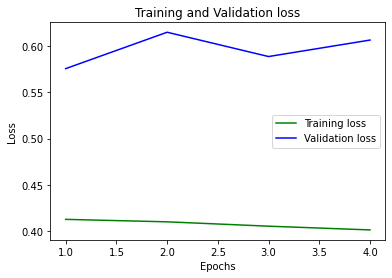

time: 198 ms (started: 2021-03-16 19:44:44 +00:00)


In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,5)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

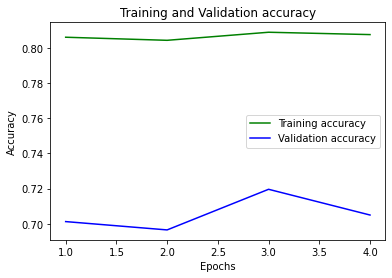

time: 197 ms (started: 2021-03-16 19:44:53 +00:00)


In [ ]:
loss_train = history.history['binary_accuracy']
loss_val = history.history['val_binary_accuracy']
epochs = range(1,5)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# DenseNet

---



In [ ]:
import numpy as np
import cv2
import pandas as pd
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os

time: 6.77 ms (started: 2021-03-18 03:00:09 +00:00)


In [ ]:
# configs
MODELS_FOLDER = '/content/drive/My Drive/df/models'
BASE_FOLDER = '/content/drive/My Drive/df'
TRAIN_SAMPLE_VIDEOS = 'train_sample_videos'
TRAIN_INPUT = 'input'
TEST_VIDEOS = 'test_videos'
TRAIN_FRAMES_FOLDER = 'train_frames'
VALID_FRAMES_FOLDER = 'valid_frames'
TEST_FRAMES_FOLDER = 'test_frames'
DATA_FOLDER = 'data'
TRAIN_FOLDER = 'train'
VALID_FOLDER = 'valid'
TEST_FOLDER = 'test'
TRAIN_FACE = 'train_face'
VALID_FACE = 'valid_face'
METADATA = 'metadata'
INPUT_SHAPE = (224, 224) 
BATCH_SIZE = 32

SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)

time: 26.6 ms (started: 2021-03-18 03:00:12 +00:00)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FACE)
valid_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FACE)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    classes=['REAL', 'FAKE'],
    class_mode='binary',
    seed= SEED)

val_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    classes=['REAL', 'FAKE'],
    class_mode='binary',
    seed= SEED)

Found 12000 images belonging to 2 classes.
Found 6996 images belonging to 2 classes.
time: 1min 12s (started: 2021-03-18 03:00:16 +00:00)


In [ ]:
print(f"Total REAL train: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FACE, 'REAL')))}")
print(f"Total FAKE train: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FACE, 'FAKE')))}")
print(f"Total REAL valid: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FACE, 'REAL')))}")
print(f"Total FAKE valid: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FACE, 'FAKE')))}")

Total REAL train: 6000
Total FAKE train: 6000
Total REAL valid: 999
Total FAKE valid: 5997
time: 185 ms (started: 2021-03-17 07:17:41 +00:00)


In [ ]:
val_gen.class_indices

{'FAKE': 1, 'REAL': 0}

time: 4.12 ms (started: 2021-03-18 03:01:28 +00:00)


In [ ]:
densenet = DenseNet121(
    weights='/content/drive/My Drive/df/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

for layer in densenet.layers:
    layer.trainable = False

def build_model(densenet):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(lr=5e-4, beta_1=0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = True),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
        )
    
    return model

time: 2.95 s (started: 2021-03-18 03:04:56 +00:00)


time: 10.3 ms (started: 2021-03-18 03:05:01 +00:00)


In [ ]:
model = build_model(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [ ]:
CHECKPOINT = "weights-improvement6-{epoch:01d}.h5"
weights_path = os.path.join(MODELS_FOLDER, CHECKPOINT)

from tensorflow.keras.callbacks import ModelCheckpoint
ckp_loss = ModelCheckpoint(weights_path, save_best_only=True, verbose=1, 
                      monitor='val_loss', mode='min')
ckp_accu = ModelCheckpoint(weights_path, save_best_only=True, verbose=1, 
                      monitor='val_binary_accuracy', mode='max')

time: 3.8 ms (started: 2021-03-18 03:05:12 +00:00)


In [ ]:
# early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)

time: 2.51 ms (started: 2021-03-18 03:05:16 +00:00)


In [ ]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

train_history_step1 = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples//BATCH_SIZE,
    validation_steps=val_gen.samples//BATCH_SIZE,
    epochs=10,
    callbacks=[ckp_loss, ckp_accu, early_stopping_cb, checkpoint]
)  

Epoch 1/10
 18/375 [>.............................] - ETA: 31:17 - loss: 0.5498 - binary_accuracy: 0.6962

In [ ]:
hist_df1 = pd.DataFrame(train_history_step1.history) 
hist_csv_file = '/content/drive/My Drive/df/DenseHistory1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df1.to_csv(f)

time: 163 ms (started: 2021-03-17 17:32:28 +00:00)


In [ ]:
model.save('/content/drive/My Drive/df/denseNetBD1.h5')
model.save_weights('/content/drive/My Drive/df/denseNetBDweight1.h5')

time: 2.48 s (started: 2021-03-17 17:31:58 +00:00)


In [ ]:
model = models.load_model('/content/drive/My Drive/df/denseNetBD1.h5')
model.summary()
model.load_weights('/content/drive/My Drive/df/denseNetBDweight1.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [ ]:
for layer in model.layers:
    layer.trainable = True

checkpoint = ModelCheckpoint('model1.h5', save_best_only=True)

train_history_step2 = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples//BATCH_SIZE,
    validation_steps=val_gen.samples//BATCH_SIZE,
    epochs=5,
    callbacks=[ckp_loss, ckp_accu, early_stopping_cb, checkpoint]
)

Epoch 1/3
375/375 [==============================] - 5489s 15s/step - loss: 0.4856 - binary_accuracy: 0.7648 - val_loss: 0.5600 - val_binary_accuracy: 0.6940

Epoch 00001: val_loss improved from inf to 0.56004, saving model to /content/drive/My Drive/df/models/weights-improvement6-1.h5

Epoch 00001: val_binary_accuracy improved from -inf to 0.69395, saving model to /content/drive/My Drive/df/models/weights-improvement6-1.h5
Epoch 2/3
375/375 [==============================] - 2885s 8s/step - loss: 0.4883 - binary_accuracy: 0.7627 - val_loss: 0.5676 - val_binary_accuracy: 0.6884

Epoch 00002: val_loss did not improve from 0.56004

Epoch 00002: val_binary_accuracy did not improve from 0.69395
Epoch 3/3
375/375 [==============================] - 2852s 8s/step - loss: 0.4782 - binary_accuracy: 0.7712 - val_loss: 0.5455 - val_binary_accuracy: 0.7015

Epoch 00003: val_loss improved from 0.56004 to 0.54547, saving model to /content/drive/My Drive/df/models/weights-improvement6-3.h5

Epoch 000

In [ ]:
hist_df2 = pd.DataFrame(train_history_step2.history) 
hist_csv_file = '/content/drive/My Drive/df/DenseHistory2.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df2.to_csv(f)

In [ ]:
model.save('/content/drive/My Drive/df/DenseNetLatest.h5')
model.save_weights('/content/drive/My Drive/df/weightsDenseNet
Latest.h5')

time: 776 ms (started: 2021-02-23 08:38:24 +00:00)


In [ ]:
import json, codecs
with codecs.open('/content/drive/My Drive/df/history.json', 'r', encoding='utf-8') as file:
  XceptionHistory = json.loads(file.read())

import json, codecs
with codecs.open('/content/drive/My Drive/df/AnkitHistory2.json', 'r', encoding='utf-8') as file:
  DenseHistory = json.loads(file.read())

time: 451 ms (started: 2021-03-24 06:32:26 +00:00)
